In [1]:
import sys
import os
import numpy as np
import random as rand
import math
import matplotlib.pyplot as plt
from pathlib import Path
from multiprocessing import Pool
from functools import partial

In [2]:
def readInput(filename):
    with open(filename) as f:
        numWizards = int(f.readline())
        numConstraints = int(f.readline())
        constraints = []
        shot_in_the_dark = []
        wizards = set()
        for _ in range(numConstraints):
            c = f.readline().split()
            constraints.append(c)
            for w in c:
                if w not in wizards:
                    shot_in_the_dark.append(w)
                wizards.add(w)    
    wizards = list(wizards)
    wizards.sort()
    dictWizards = {}
    for i in range(len(wizards)):
        dictWizards[wizards[i]] = i
    
    for i in constraints:
        for j in range(3):
            i[j] = dictWizards[i[j]]
        if int(i[0]) > int(i[1]):
            i[0], i[1] = i[1], i[0]
    return numWizards, numConstraints, list(range(numWizards)), constraints

def displayInput(filename):
    n, c, names, constraints = readInput(filename)
    string = str(n) + "\n"
    string += " ".join(names) + "\n"
    string += str(c) + "\n"
    for i in constraints:
        string += " ".join(i) + "\n"
    print(string)
    
def reinterpret(num, seq):
    with open('./Staff_Inputs/staff_' + str(num) +  '.in') as f:
        numWizards = int(f.readline())
        numConstraints = int(f.readline())
        constraints = []
        wizards = set()
        for _ in range(numConstraints):
            c = f.readline().split()
            constraints.append(c)
            for w in c:
                wizards.add(w)
    wizards = sorted(list(wizards))
    dictWizards = {}
    for i in range(len(wizards)):
        dictWizards[i] = wizards[i]
    newOrder = [0] * len(seq)
    for i in range(len(seq)):
        newOrder[seq[i]] = dictWizards[i]
    writeOutput(num, 0, newOrder, constraints)
    
def writeOutput(num, idx, order, constraints):
    string = str(len(order))
    string += "\n"
    for i in order:
        string += i + " "
    string += "\n" + str(len(constraints)) + "\n"
    for i in constraints:
        for j in i: 
            string += j + " "
        string += "\n"
    f = open('./outputs/input' + str(num) + '_' + str(idx) + '.out', 'w')
    f.write(string)
    f.close()
    
def instanceValidator(num, idx):
    file = './outputs/input' + str(num) + '_' + str(idx) + '.out'
    input_size = str(num)
    !python instance_validator.py $file $input_size
    
def eric_bachman(filename, sol):
    output_file = 'eric_bachman.out'
    f = open(output_file, 'w')
    !python output_validator.py $filename $output_file

In [3]:
# assigment is a dict: wix->index, constraints: list((a,b,c) ... (x,y,z))
def h(assigment, constraints):
    conflicts = 0
    for constraint in constraints:
        try:
            t0, t1 = assigment[constraint[0]], assigment[constraint[1]]
        except:
            print(constraint)
            print(len(assigment), assigment)
        a = t0 if (t0 < t1) else t1
        b = t0 + t1 - a
        c = assigment[constraint[2]]
        if a<c and c<b:
            conflicts += 1
    return conflicts

In [4]:
#currently gives a random assigment
def getAssigment(numWiz, wizs):
    indecies = list(range(1,numWiz+1))
    rand.shuffle(indecies)
    ass = {wizs[i]:indecies[i] for i in range(len(wizs))}
    return ass

In [5]:
#Hill climbing solver
def solve(wizs, constraints):
    numWiz = len(wizs)
    numCons = len(constraints)
    ass = getAssigment(numWiz, wizs)
    conflicts = h(ass, constraints) 
    while conflicts > 0:
        best_score = conflicts
        for i in range(numWiz):
            for j in range(i+1,numWiz):
                x = ass[wizs[i]]
                y = ass[wizs[j]]
                ass[wizs[i]] = y
                ass[wizs[j]] = x

                newScore = h(ass, constraints)
                if newScore == 0:
                    return ass
                if newScore < best_score:
                    best_ass = ass.copy()
                    best_score = newScore
                    
                ass[wizs[i]] = x
                ass[wizs[j]] = y
        if best_score >= conflicts:
            ass = getAssigment(numWiz, wizs)
            conflicts = h(ass, constraints) 
        else:
            conflicts = best_score
            ass = best_ass.copy()

In [7]:
# Calculate probabily for given state
def acceptance_prob(oldCost, newCost, T):
    exponent = (oldCost - newCost)/(1.0*T)
#   if exponent > 0 probability will be >1. just return 1 to prevent crazy big numbers.
    if exponent > 0:
        return 1
    p = math.e**exponent
    return p

In [8]:
# Simulated annealing
def anneal(wizs, constraints, start, bestAss=None):
    numWiz = len(wizs)
    numCons = len(constraints)
    ass = start.copy()
    conflicts = h(ass, constraints) 
    
    bestScore = numCons
    if bestAss == None:
        bestAss = [start.copy()]
    
#     meta parameters, T should be 1, 0.8<alpha<0.99, 100<iterations<1000 should work well
    T = 1.0
    T_min = 0.00001
    alpha = 0.95
    iterations = int(0.15*numWiz**2)
    while conflicts > 0 and T > T_min:
        for i in range(iterations):
#         Choosing 2 random wizards
            wizA, wizB = rand.sample(wizs, 2)
            
            x = ass[wizA]
            y = ass[wizB]
            ass[wizA] = y
            ass[wizB] = x
            newScore = h(ass, constraints)
#             if solution found, return
            if newScore == 0:
                print("0 conflicts SHABANG")
                reinterpret(numWiz, ass)
                string = './outputs/input' + str(numWiz) + '_0.out'
                !python instance_validator.py $string $numWiz
                exit()
                return ass, None
            elif newScore < bestScore:
                bestScore = newScore
                bestAss = [ass.copy()]
                if newScore<3:
                    print(newScore)
#                 calculating probability
            ap = acceptance_prob(conflicts, newScore, T)
#             save change
            if ap > rand.random(): 
                conflicts = newScore
#             revert change
            else: 
                ass[wizA] = x
                ass[wizB] = y
#         reduce tempreture
        T *= alpha
    return bestAss[0], bestAss

In [9]:
# Use constraint statistics to generate more likely starting points 
def potential_neighbors(input_size, constraints, plot, thrsh):
    stats = np.zeros(input_size*input_size+1)
    for i in constraints:
        stats[i[0]*input_size+i[1]] += 1
    if plot:
        plt.plot(stats[stats!=0])
        plt.title("appearances")
        plt.show()
        print("greater then threshold neighbor appearance = " + str(len(stats[stats>thrsh])))
        print
    highPairs = [i for i, x in enumerate(stats>thrsh) if x]
    potential_neighbors = []
    for i in highPairs:
        potential_neighbors.append( (i//input_size,i%input_size) )
    return potential_neighbors

def goodStart(numWiz, wizs, constraints, plot=False, thrsh=1):
    poteneighbors = potential_neighbors(numWiz, constraints, plot, thrsh)
    rand.shuffle(poteneighbors)
    andreysAss = []
    for i in poteneighbors:
        neighborA, neighborB = i[0], i[1]
        if neighborA not in andreysAss:
            andreysAss.append(neighborA)
        if neighborB not in andreysAss:
            andreysAss.append(neighborB)
    residual = []
    for i in range(numWiz):
        if i not in andreysAss:
            residual.append(i)
    for i in range(numWiz-len(andreysAss)):
        rand.shuffle(residual)
        andreysAss.append(residual.pop())
    return andreysAss

number of wizards: 340
initial number of conflicts: 1180


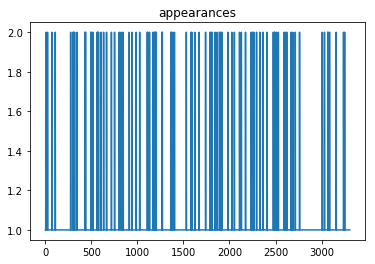

greater then threshold neighbor appearance = 92
CPU times: user 316 ms, sys: 216 ms, total: 532 ms
Wall time: 333 ms


In [10]:
%%time 
numWiz, numCons, wizs, constraints = readInput('Staff_Inputs/staff_340.in')
start = wizs.copy()
rand.shuffle(start)
print("number of wizards: " + str(numWiz))
print('initial number of conflicts:', h(start, constraints))
goodStart(numWiz, wizs, constraints,plot=True)
# sol, bestAss = anneal(wizs, constraints, start)
# print('solution conflicts', h(sol, constraints))
# print('best score:', h(sol, constraints))

In [14]:
%%time
cores = 4
partial_aneal = partial(anneal, wizs, constraints)
p = Pool(cores)
starts = [goodStart(numWiz, wizs, constraints) for _ in range(20)]
results = p.map(partial_aneal, starts)

2
2
2
2
2
1
1
2
1
2
1
1
0 conflicts SHABANG
Success!
2
0 conflicts SHABANG
Success!
2
2
2
2
1


Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


[221, 306, 72]


  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-8:
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Process ForkPoolWorker-2:
Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
Traceback (most recent call last):
  F

[139, 212, 187]
[27, 298, 53]


Traceback (most recent call last):


[80, 160, 189]


  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-18:
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))


[154, 281, 66]


  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))


340 [84, 66, 261, 112, 253, 90, 207, 97, 194, 300, 280, 179, 234, 274, 284, 93, 33, 80, 176, 225, 203, 259, 286, 331, 199, 296, 40, 59, 186, 235, 37, 167, 337, 57, 317, 145, 96, 268, 31, 142, 77, 264, 49, 185, 329, 249, 53, 309, 100, 91, 250, 256, 291, 292, 39, 13, 328, 289, 210, 228, 157, 177, 69, 213, 178, 164, 88, 245, 120, 116, 298, 252, 336, 174, 315, 151, 312, 218, 161, 1, 117, 232, 285, 28, 144, 324, 206, 239, 62, 149, 102, 308, 267, 55, 17, 184, 34, 168, 108, 7, 183, 323, 282, 223, 222, 106, 229, 154, 231, 45, 307, 110, 236, 173, 12, 48, 297, 327, 193, 22, 24, 299, 265, 122, 182, 216, 209, 288, 137, 318, 23, 109, 74, 325, 255, 201, 257, 95, 277, 180, 32, 227, 212, 198, 76, 87, 21, 333, 60, 302, 27, 92, 143, 195, 65, 305, 127, 158, 89, 67, 18, 254, 171, 278, 260, 188, 241, 25, 20, 16, 290, 41, 335, 99, 152, 147, 272, 304, 101, 104, 208, 8, 61, 81, 119, 170, 313, 15, 125, 3, 311, 247, 6, 135, 9, 205, 138, 43, 214, 146, 73, 124, 153, 301, 226, 273, 287, 42, 238, 166, 14, 155, 192,

Traceback (most recent call last):
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "<ipython-input-3-8a8e3637a6b5>", line 10, in h
    a = t0 if (t0 < t1) else t1
  File "<ipython-input-3-8a8e3637a6b5>", line 12, in h
    c = assigment[constraint[2]]
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._

340 [55, 63, 255, 105, 261, 62, 201, 86, 155, 273, 250, 176, 204, 270, 264, 89, 25, 5, 196, 185, 178, 260, 274, 330, 218, 307, 45, 48, 187, 253, 59, 174, 338, 3, 326, 160, 95, 285, 88, 129, 71, 233, 8, 132, 315, 240, 74, 296, 93, 79, 291, 263, 266, 283, 33, 2, 294, 293, 227, 209, 110, 194, 76, 206, 177, 170, 70, 229, 238, 107, 311, 269, 331, 150, 254, 138, 308, 235, 157, 10, 116, 230, 280, 32, 136, 322, 208, 225, 46, 131, 92, 312, 239, 49, 21, 200, 38, 169, 102, 35, 188, 314, 277, 199, 236, 104, 226, 128, 198, 64, 256, 122, 219, 171, 14, 52, 282, 335, 191, 22, 23, 286, 243, 100, 173, 205, 210, 292, 161, 323, 12, 113, 80, 325, 272, 181, 242, 123, 301, 189, 41, 232, 215, 190, 313, 73, 18, 306, 290, 302, 26, 84, 114, 140, 51, 305, 121, 168, 56, 65, 47, 237, 154, 265, 241, 207, 257, 16, 20, 15, 276, 24, 334, 101, 145, 126, 297, 287, 103, 141, 214, 30, 67, 54, 139, 135, 337, 17, 152, 13, 299, 222, 19, 142, 11, 186, 120, 50, 221, 81, 78, 112, 162, 309, 211, 252, 262, 36, 234, 151, 4, 134, 14

  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


[41, 163, 219]
340 [97, 64, 262, 122, 257, 94, 233, 63, 175, 288, 274, 177, 229, 315, 267, 79, 27, 85, 140, 206, 200, 235, 293, 324, 199, 284, 51, 57, 186, 234, 44, 176, 339, 0, 323, 160, 165, 259, 31, 156, 56, 256, 29, 155, 309, 242, 80, 312, 86, 84, 292, 260, 298, 296, 28, 16, 328, 294, 223, 225, 116, 95, 81, 203, 181, 148, 119, 248, 108, 124, 297, 253, 337, 189, 273, 112, 326, 241, 168, 9, 118, 238, 290, 26, 150, 322, 191, 220, 99, 132, 104, 310, 266, 41, 11, 169, 36, 190, 113, 21, 195, 308, 289, 211, 224, 90, 214, 135, 222, 59, 304, 133, 245, 154, 8, 62, 295, 334, 196, 7, 30, 299, 247, 121, 167, 216, 230, 282, 184, 311, 10, 114, 91, 321, 252, 185, 258, 106, 306, 218, 38, 232, 217, 209, 53, 82, 23, 318, 305, 314, 66, 103, 125, 173, 55, 303, 137, 166, 48, 68, 35, 231, 162, 283, 251, 180, 254, 25, 14, 13, 281, 34, 333, 115, 134, 131, 268, 287, 69, 102, 198, 19, 71, 72, 157, 136, 330, 17, 158, 15, 331, 278, 1, 147, 2, 179, 143, 50, 205, 139, 87, 75, 151, 286, 213, 271, 280, 39, 237, 17

  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))


340 [67, 60, 255, 114, 251, 81, 238, 55, 174, 300, 281, 170, 240, 290, 282, 90, 22, 75, 202, 186, 171, 231, 301, 327, 162, 306, 49, 45, 190, 245, 43, 176, 337, 70, 320, 153, 101, 269, 13, 203, 97, 249, 27, 147, 325, 246, 72, 303, 95, 76, 302, 253, 289, 292, 20, 8, 315, 287, 183, 224, 126, 167, 68, 212, 178, 148, 86, 233, 241, 120, 279, 239, 331, 156, 275, 141, 318, 229, 177, 9, 117, 187, 291, 24, 160, 326, 196, 237, 63, 145, 87, 307, 258, 35, 38, 132, 33, 172, 110, 42, 199, 312, 286, 242, 213, 136, 225, 142, 235, 53, 309, 96, 200, 158, 23, 54, 317, 322, 210, 26, 29, 299, 284, 128, 181, 205, 119, 276, 139, 321, 12, 91, 88, 316, 254, 204, 261, 89, 273, 217, 39, 227, 218, 194, 64, 99, 25, 314, 271, 313, 56, 69, 154, 152, 77, 310, 123, 155, 62, 85, 28, 259, 165, 277, 278, 189, 247, 16, 10, 5, 268, 19, 335, 105, 149, 133, 272, 283, 104, 106, 207, 21, 66, 65, 116, 184, 334, 1, 150, 11, 311, 236, 15, 138, 6, 179, 130, 40, 263, 159, 73, 108, 161, 295, 215, 274, 296, 32, 244, 185, 14, 157, 151,

  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "<ipython-input-3-8a8e3637a6b5>", line 11, in h
    b = t0 + t1 - a
KeyboardInterrupt
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)


340 [67, 71, 251, 125, 253, 95, 224, 284, 167, 289, 280, 182, 252, 75, 281, 87, 25, 72, 161, 205, 198, 269, 287, 325, 181, 311, 38, 63, 196, 240, 57, 177, 334, 52, 308, 159, 101, 267, 28, 172, 77, 262, 26, 149, 326, 248, 50, 307, 91, 84, 290, 268, 288, 294, 30, 11, 336, 302, 188, 222, 103, 194, 88, 193, 179, 152, 81, 235, 86, 80, 295, 249, 337, 150, 283, 119, 317, 197, 175, 0, 112, 243, 296, 29, 140, 324, 211, 239, 109, 145, 96, 316, 278, 35, 24, 173, 36, 174, 120, 42, 190, 310, 292, 212, 221, 111, 236, 142, 234, 53, 270, 133, 231, 164, 7, 40, 315, 323, 207, 13, 27, 299, 227, 113, 168, 204, 216, 276, 128, 322, 18, 122, 108, 313, 266, 200, 247, 79, 297, 210, 32, 219, 220, 201, 46, 73, 17, 330, 271, 303, 58, 100, 154, 158, 61, 304, 148, 169, 41, 68, 15, 238, 160, 277, 263, 202, 264, 20, 23, 5, 300, 34, 339, 102, 146, 123, 255, 286, 104, 155, 230, 10, 44, 51, 136, 147, 327, 8, 151, 2, 320, 223, 22, 139, 6, 213, 138, 49, 254, 137, 82, 107, 184, 319, 225, 261, 291, 47, 229, 206, 12, 141, 13

  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "<ipython-input-3-8a8e3637a6b5>", line 13, in h
    if a<c and c<b:
KeyboardInterrupt
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-8a8e3637a6b5>", line 13, in h
    if a<c and c<b:
KeyboardInterrupt
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
   

340 [83, 88, 264, 107, 252, 68, 247, 70, 169, 288, 278, 201, 248, 254, 273, 86, 24, 64, 153, 204, 192, 242, 320, 326, 126, 286, 40, 43, 188, 246, 55, 178, 334, 53, 294, 165, 105, 260, 30, 163, 63, 270, 23, 154, 322, 245, 50, 336, 97, 94, 309, 269, 291, 289, 22, 6, 331, 302, 223, 239, 119, 162, 69, 211, 179, 143, 127, 240, 102, 104, 317, 262, 330, 167, 306, 132, 332, 195, 177, 1, 113, 234, 293, 34, 160, 325, 206, 235, 121, 140, 96, 318, 256, 52, 35, 161, 37, 180, 103, 15, 187, 305, 280, 199, 226, 110, 232, 128, 220, 56, 300, 131, 244, 172, 19, 67, 304, 335, 197, 7, 21, 290, 230, 120, 185, 209, 222, 282, 139, 327, 8, 116, 93, 307, 258, 189, 261, 80, 292, 219, 41, 212, 217, 186, 62, 60, 20, 316, 266, 315, 46, 100, 130, 194, 57, 299, 142, 176, 82, 73, 29, 257, 166, 298, 231, 200, 250, 28, 13, 2, 274, 36, 337, 111, 159, 87, 265, 279, 78, 101, 224, 17, 49, 72, 144, 152, 319, 9, 155, 16, 328, 287, 14, 156, 18, 193, 137, 39, 213, 150, 90, 91, 171, 313, 229, 277, 285, 108, 228, 136, 12, 149, 18

  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-4ecb4205cca3>", line 25, in anneal
    newScore = h(ass, constraints)
  File "<ipython-input-3-8a8e3637a6b5>", line 11, in h
    b = t0 + t1 - a
KeyboardInterrupt
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/eilam/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-4ecb4205cca3>", line 25, in annea

KeyboardInterrupt: 

1
0 conflicts SHABANG
Success!
